### Waveform Analysis

#### Initial Setup, Imports and Visuals

Using "Fpz-Cz"-- voltage difference bewteen electroide at center of forehead and top of head (this can be swapped to different electrodes)

Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_20040\1737552590.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw(psg_file, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_20040\1737552590.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw(psg_file, preload=True)


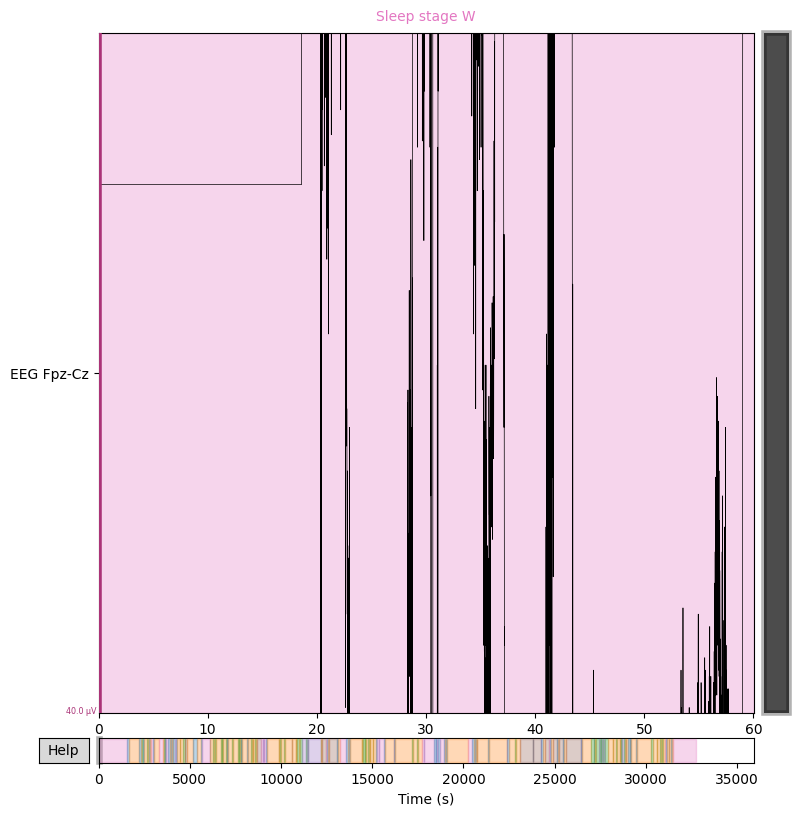

In [83]:
import numpy as np
import pandas as pd
import mne 
import matplotlib.pyplot as plt

psg_file = "../data/sleep_waves/ST7011J0-PSG.edf"
hypnogram = "../data/sleep_waves/ST7011JP-Hypnogram.edf"

# Loading new EEG data in
raw = mne.io.read_raw(psg_file, preload=True)
annotations = mne.read_annotations(hypnogram)
raw.set_annotations(annotations) 

# Focus on EEG channel: 
# Fpz-Cz -- voltage diff between electrode at forehead center and top of head
# One of two best for sleep data
raw.pick(['EEG Fpz-Cz'])

raw.plot(duration=60, n_channels=1, title='Raw EEG');

# The warnings that come up are not a concern: 

#### Preprocessing the Signal

EEG contains a huge range of freqs-- but sleep-related brain activity is concentrated in slow to moderate freqs. So by setting our limits to 0.5 - 40 Hz, we're filtering out all the non-sleep related (outside movement, muscle twitches, etc.)  

We're using "firwin" (Finite Impulse Response) because it's useful for isolating clean frequency bands

In [53]:
raw.filter(0.5, 40., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)



<RawEDF | ST7011J0-PSG.edf, 1 x 3590000 (35900.0 s), ~27.4 MiB, data loaded>

#### Segment into 30s Epochs (Sleep Scoring Standard)

30 second epochs have been the longstanding clinical and industry standard for measuring and classifying sleep-related brainwaves  

For clarity's sake, sleep stages do *not* change every second... they tend to last minutes at least. However, 30s windows are great for catching transitions between the stages with minimal lag  

**A thought**: if we encounter difficulty with classification, we could experiment with 60s window (would get more stable features)... BUT that runs the real risk of accidently mixing stages.

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 231 events and 3001 original time points ...
0 bad epochs dropped


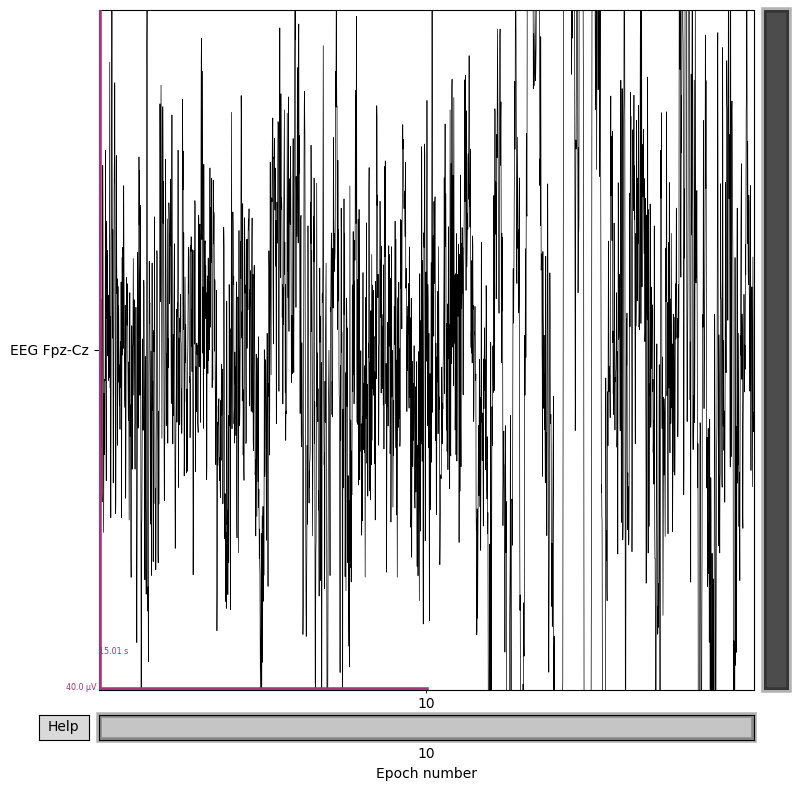

In [54]:
# Each annotation = 30s
# We'll match that in epoching for clarity's sake (industry standard)

events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True)


epochs[10].plot(title='Epoch 10: Raw EEG');

#### Extract Sleep Stage Labels

Mapping MNE annotations to the standard numeric sleep stages:

In [74]:
def extract_labels_from_events(events: np.ndarray, event_id: dict):
    '''
    Maps MNE event integer codes to standardized sleep labels 

    0: Wake
    1: N1
    2: N2
    3: N3 (includes Stage 4)
    4: REM

    Args: 
        events (np.ndarray): array of shape (n_epochs, 3) from MNE Epochs.events
        event_id (dict): Mapping from annotation strings to event codes
    '''

    reverse_event_map = {v: k for k, v in event_id.items()} 

    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3',  # Merged with Stage 3
        'Sleep stage R': 'REM'
    }
    
    labels = []
    for e in events: 
        raw_label = reverse_event_map.get(e[-1]) 
        if raw_label in stage_map: 
            labels.append(stage_map[raw_label])

        else: 
            # Dropping unknown / invalid labels
            labels.append(-1) 

    return labels


#### Feature Extraction (Band Power):

Computing avergae power in key freq bands per epoch



In [75]:
from mne.time_frequency import psd_array_welch

# Get raw epoch data as numpy array
epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
sfreq = epochs.info['sfreq']    # typically 100 Hz for Sleep-EDF

# Compute Power Spectral Density
psds, freqs = psd_array_welch(epoch_data, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

def bandpower(psds: np.ndarray, freqs: np.ndarray, band: tuple): 
    ''' 
    Computes the mean power in a specific freq band for all epochs

    Args: 
        psds (np.array): Power spectral densities, shape (n_epochs, n_channels, n_freqs)
        freqs (np.ndarray): Array of freq values
        band (tuple): Lower and upper bounds of thr freq band (0.5-40Hz) 
    '''

    low, high = band
    idx = (freqs >= low) & (freqs <= high) 
    
    return psds[:, :, idx].mean(axis=-1).mean(axis=1) 


Effective window size : 2.560 (s)


In [76]:
features = pd.DataFrame({
    'delta': bandpower(psds, freqs, (0.5, 4)), 
    'theta': bandpower(psds, freqs, (4, 8)), 
    'alpha': bandpower(psds, freqs, (8, 13)), 
    'beta': bandpower(psds, freqs, (13, 30))
})

labels = extract_labels_from_events(epochs.events, event_id)
features['label'] = labels
features = features[features['label'] != -1]
features

,delta,theta,alpha,beta,label
0,5.894554e-12,3.310751e-12,1.928782e-12,2.361454e-12,Wake
1,6.733962e-12,2.182173e-12,1.099113e-12,8.344730e-13,N1
2,2.656462e-11,3.855939e-12,1.444914e-12,8.650193e-13,N2
3,2.355401e-11,1.121286e-12,1.828405e-12,4.989318e-13,N1
4,4.371054e-11,2.542881e-12,1.271729e-12,8.339689e-13,N2
...,...,...,...,...,...
226,1.657383e-11,5.353038e-12,2.830488e-12,5.964535e-13,N1
227,3.012973e-11,3.662102e-12,1.529854e-12,4.682529e-13,N2
228,8.183535e-12,8.212576e-13,1.126325e-12,2.910054e-13,N1
229,3.256719e-11,4.368487e-12,1.740246e-12,5.843580e-13,N2


## Training a Basic Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

X = features.drop(columns=['label'])
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          N1       0.57      0.73      0.64        11
          N2       0.65      0.76      0.70        17
          N3       0.70      0.58      0.64        12
         REM       0.00      0.00      0.00         2
        Wake       0.33      0.20      0.25         5

    accuracy                           0.62        47
   macro avg       0.45      0.46      0.45        47
weighted avg       0.58      0.62      0.59        47



c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Testing out custom-built functions:

In [72]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.run_pipeline import tune_and_train_full

rf_wave = tune_and_train_full(RandomForestClassifier, 
                    'Random Forest', 
                    X_train, 
                    y_train) 

ValueError: Sample too small! Estimated ~3.60 samples per class, but min required is 5. Increase sample_frac (currently 0.1).